# Single Particle Model (SPM): Fast discharge with concentration dependent diffusion 

## Model Equations

The SPM consists of two spherically symmetric diffusion equations: one within a representative negative particle ($\text{k}=\text{n}$) and one within a representative positive particle ($\text{k}=\text{p}$). In the centre of the particle the standard no-flux condition is imposed. Since the SPM assumes that all particles in an electrode behave in exactly the same way, the flux on the surface of a particle is simply the current $I$ divided by the thickness of the electrode $L_{\text{k}}$. The concentration of lithium in electrode $\text{k}$ is denoted $c_{\text{k}}$ and the current is denoted by $I$. All parameters in the model stated here are dimensionless and are given in terms of dimensional parameters at the end of this notebook. The model equations for the SPM are then: 
$$
\begin{align}
\mathcal{C}_{\text{k}} \frac{\partial c_{\text{s,k}}}{\partial t} &= -\frac{1}{r_{\text{k}}^2} \frac{\partial}{\partial r_{\text{k}}} \left(r_{\text{k}}^2 N_{\text{s,k}}\right), \\
N_{\text{s,k}} &= -D_{\text{s,k}}(c_{\text{s,k}}) \frac{\partial c_{\text{s,k}}}{\partial r_{\text{k}}}, \quad \text{k} \in \text{n, p}, 
\end{align}
$$
$$
N_{\text{s,k}}\big|_{r_{\text{k}}=0} = 0, \quad \text{k} \in \text{n, p}, \quad \ \ - \frac{a_{R, \text{k}}\gamma_{\text{k}}}{\mathcal{C}_{\text{k}}} N_{\text{s,k}}\big|_{r_{\text{k}}=1} = 
\begin{cases}
		  \frac{I}{L_{\text{n}}}, \quad &\text{k}=\text{n}, \\ 
		  -\frac{I}{L_{\text{p}}}, \quad &\text{k}=\text{p}, 
\end{cases} \\
c_{\text{s,k}}(r_{\text{k}},0) = c_{\text{s,k,0}}, \quad \text{k} \in \text{n, p},$$
where $D_{\text{s,k}}$ is the diffusion coefficient in the solid, $N_{\text{s,k}}$ denotes the flux of lithium ions in the solid particle within the region $\text{k}$, and $r_{\text{k}} \in[0,1]$ is the radial coordinate of the particle in electrode $\text{k}$. 

### Voltage Expression
The terminal voltage is obtained from the expression: 
$$
V = U_{\text{p}}(c_{\text{p}})\big|_{r_{\text{p}}=1} - U_{\text{n}}(c_{\text{n}})\big|_{r_{\text{n}}=1} -2\sinh^{-1}\left(\frac{I}{j_{\text{0,p}} L_{\text{p}}}\right) - 2\sinh^{-1}\left(\frac{I}{j_{\text{0,n}} L_{\text{n}}}\right)
$$
with the exchange current densities given by
$$j_{\text{0,k}} =  \frac{\gamma_{\text{k}}}{\mathcal{C}_{\text{r,k}}}(c_{\text{k}})^{1/2}(1-c_{\text{k}})^{1/2}  $$

More details can be found in [[3]](#References).

## Example solving SPM using PyBaMM

Below we show how to solve the Single Particle Model, using the default geometry, mesh, parameters, discretisation and solver provided with PyBaMM. In this notebook we explicitly handle all the stages of setting up, processing and solving the model in order to explain them in detail. However, it is often simpler in practice to use the `Simulation` class, which handles many of the stages automatically, as shown [here](../simulation-class.ipynb).

First we need to import `pybamm`, and then change our working directory to the root of the pybamm folder. 

In [90]:
# %pip install DFO-LS -q
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
import dfols
from scipy.optimize import curve_fit
from scipy import integrate

# from multiprocessing import Process, Pool

# from scipy.optimize import minimize
print(pybamm.__path__[0])
%matplotlib widget


c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


# Load pulse testing data

In [129]:
SOC_0 = 1
SOC_name = SOC_0
Q_nom = 4.6

# load data import ESC data from file
data = pd.read_csv(
    "./fast_discharge/2C_pulse_test_data_DCR_Cell_43.csv"#, comment="#", header=None
)

# current profile for running sim
pulse_current = data[['time_s', 'I_A']].to_numpy()

# load data import ESC data from file
# esc_start = raw_data[-raw_data['I_A']>1].index[0]
# esc_end = raw_data[raw_data['Time (s)']>15*60].index[0]
# esc_end =len(raw_data)
# T_amb = np.mean(raw_data['Cell Temperature'][(raw_data.index < esc_start) & (raw_data['Cell Temperature'] >0)])
# data = raw_data[raw_data.keys()].loc[esc_start:esc_end].copy()
df_labels = ['t', 'V', 'mAh', 'Temp','Q', 'I']
data.set_axis(df_labels, axis=1, inplace=True)
data['I_C'] = data.I/Q_nom 
AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
data['SOC'] = SOC_0 - AhT_calculated/4.2
T_amb = data.Temp.iloc[0]
data = data[np.where(data.I>1)[0][0]-1::]
data.t = data.t-data.t.iloc[0]
data.reset_index(drop=True, inplace=True)

# data = pd.read_csv(
#     "./fast_discharge/2C_pulse_test_data_DCR_Cell_43.csv"#, comment="#", header=None
# )
# df_labels = ['t', 'V', 'AhT','Temp', 'Q', 'I']
# data.set_axis(df_labels, axis=1, inplace=True)
# data.AhT = -data.AhT/1000 
# data['I_C'] = data.I/4.6
# # data['SOC'] = 1-data.AhT/4.2
# data['SOC'] = 1-data.AhT/4.2

data

,t,V,mAh,Temp,Q,I,I_C,SOC
0,0.000000,4.196351,0.000000,23.009535,2292.862303,-0.000000,-0.000000,0.997024
1,10.000000,4.102098,-24.737959,23.143507,24.737959,8.997992,1.956085,0.991074
2,20.000001,4.084767,-49.730813,23.048939,49.730813,8.997008,1.955871,0.985124
3,30.000001,4.070548,-74.723642,23.372046,74.723642,8.996023,1.955657,0.979173
4,40.000002,4.057905,-99.716322,23.639988,99.716322,8.997401,1.955957,0.973222
...,...,...,...,...,...,...,...,...
4089,5532.090263,3.204265,-4073.620207,24.183754,4072.425625,8.995825,1.955614,0.064860
4090,5542.090263,3.162594,-4098.612888,24.231037,4097.418306,8.995825,1.955614,0.058910
4091,5552.090264,3.106940,-4123.605462,24.412292,4122.410880,8.996416,1.955743,0.052960
4092,5562.090264,3.029937,-4148.598107,24.459576,4147.403525,8.997204,1.955914,0.048485


# Find and plot indices of pulse rest 

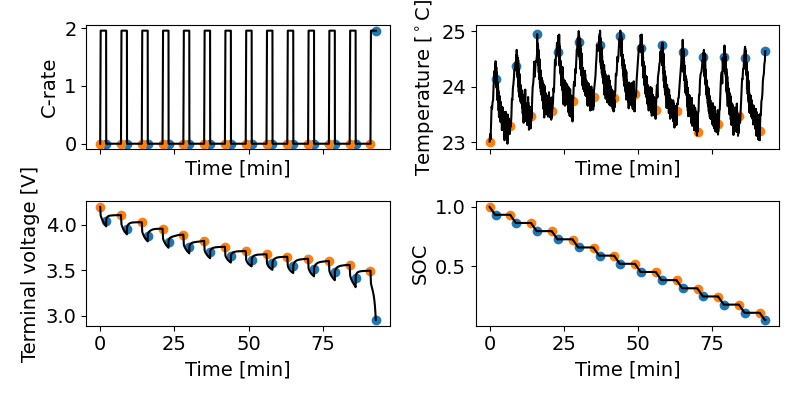

In [130]:
# find pulse indices
I = data.I
pulse_current = max(I)
i1 = np.where((np.diff(I)<-0.1))[0]
i1 = i1+1
i1 = np.append(i1,len(I)-1)
i2 = np.where((np.diff(I)>0.1) & (I[1:]>pulse_current-0.1)& (I[1:]<pulse_current+0.1))[0]
# i2 = np.insert(i2,0,1)
# plot
fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
ax = ax.flatten()
linestyles = ['-','--',':','.-']*2

t = data.t/60
xlabel = "Time [min]"
data_color = 'k'
ax[0].plot(t,data.I_C, label='Data', color = data_color)
ax[0].scatter(t[i1], data.I_C[i1])
ax[0].scatter(t[i2], data.I_C[i2])
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel('C-rate')

ax[2].plot(t, data.V,color = data_color)
ax[2].scatter(t[i1], data.V[i1])
ax[2].scatter(t[i2], data.V[i2])
ax[2].set_xlabel(xlabel)
ax[2].set_ylabel('Terminal voltage [V]')

ax[1].plot(t, data.Temp, color = data_color)
ax[1].scatter(t[i1], data.Temp[i1])
ax[1].scatter(t[i2], data.Temp[i2])
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel('Temperature [$^\circ$C]')

ax[3].plot(t, data.SOC, color = data_color)
ax[3].scatter(t[i1], data.SOC[i1])
ax[3].scatter(t[i2], data.SOC[i2])
ax[3].set_xlabel(xlabel)
ax[3].set_ylabel('SOC')

plt.tight_layout()
plt.show()


In [131]:
def plot_pulse(data, solutions, labels = []):
    fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
    ax = ax.flatten()
    linestyles = ['-','--',':','.-']*2

    t = data.t/60
    xlabel = "Time [min]"
    data_color = 'k'
    ax[0].plot(t,data.I_C, label='Data', color = data_color)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate')


    ax[2].plot(t, data.V,color = data_color)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('Terminal voltage [V]')

    ax[1].plot(t, data.Temp, color = data_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Temperature [$^\circ$C]')

    ax[3].plot(t, data.SOC, color = data_color)
    ax[3].set_xlabel(xlabel)
    ax[3].set_ylabel('SOC')

    sim_colors = ['r','g','b','m']*2
    for i,solution in enumerate(solutions):
        t = solution["Time [s]"].entries
        x = solution["x [m]"].entries[:, 0]
        I = solution['C-rate']
        V = solution['Terminal voltage [V]']
        T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
        soc = solution['R-averaged negative particle concentration']

        x_plot = t/60
        ax[0].plot(x_plot, I(t), linestyle=':',color = sim_colors[i])
        ax[2].plot(x_plot, V(t), linestyle=':',color = sim_colors[i])
        ax[1].plot(x_plot, T,linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)
        ax[3].plot(x_plot, soc(t=t, x=x[-1]),linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)


    plt.tight_layout()
    plt.show()


# Set up nominal model

2023-07-20 19:06:06.085 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


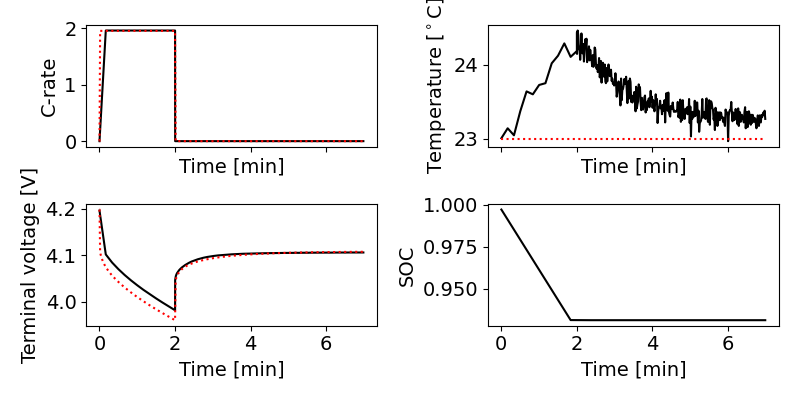

In [132]:
# set up pulse data
pulse = data[i2[0]:i2[1]].copy()
pulse.t = pulse.t-pulse.t.iloc[0]

# define parameters for simulation
SOC_0 = pulse.SOC.iloc[0]
pulse_current = pulse[['t','I']].to_numpy()

# set up and solve model
solutions = []
options = {
    # "thermal": "x-lumped",
}
model = pybamm.lithium_ion.SPMe(options = options)
param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
param.update({
    "Lower voltage cut-off [V]": 0,
    "Nominal cell capacity [A.h]": 4.6,
    "Typical current [A]":4.6,
    "Negative tab width [m]":2.5e-2,
    "Positive tab width [m]":2.5e-2,
    "Negative electrode thickness [m]":62E-06*4.2/5,
    "Positive electrode thickness [m]":67E-06*4.2/5,
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Edge heat transfer coefficient [W.m-2.K-1]":5,
    "Total heat transfer coefficient [W.m-2.K-1]":5,
    "Negative electrode diffusivity [m2.s-1]": 8.0E-14, 
    "Positive electrode diffusivity [m2.s-1]": 8.0E-15, 
    "Ambient temperature [K]": 23+273.15,
    "Initial temperature [K]": 23 + 273.15,
    "Typical electrolyte diffusivity [m2.s-1]":5.35E-10,
    "Typical electrolyte conductivity [m2.s-1]":1.3*10,

}, check_already_exists = False)
experiment = pybamm.Experiment(
        # [
        # "Run pulse (A) until 3.0 V"
        # ],
        [
        # "Run pulse (A) until 3.0 V", 
        ("Rest for 0.00001 minutes",
        "Discharge at 1.95 C for 2 minutes or until 2.8 V", 
        "Rest for 5 minutes",) 

        ],
        drive_cycles={
            'pulse': pulse_current
        }
        , period = "1 second"
    )
sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
solution = sim.solve( initial_soc=SOC_0)
solutions.append(solution)

# plot simulation results 
plot_pulse(pulse,solutions)

# Set up loss function for parameterization

In [161]:
# # run simulation with input k to scale D and output error metric
# # Input and output are np.array
def simulate_pulse(k:np.ndarray): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k[1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    # t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    t_error = pulse.t[pulse.I ==0].to_numpy() #  & (pulse.I ==0)
    # rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    # rmse_dV = np.sqrt(np.mean(np.square(np.diff(pulse.V[(pulse.V > 3.0)])- np.diff(V(t_error)))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    rmse_V = np.sum(np.square(pulse.V[pulse.I ==0]- V(t_error)))

    return np.array([rmse_V])
    

# test function
# print(simulate_pulse(np.array([1,1])))


def simulate_pulse_pos(kp:np.ndarray, kn): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*kp[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*kn,
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    # t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    # rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    # # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    # rmse_dV = np.sqrt(np.mean(np.square(np.diff(pulse.V[(pulse.V > 3.0)])- np.diff(V(t_error)))))
    # # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    t_error = pulse.t[(pulse.I ==0)].to_numpy() #  & (pulse.I ==0)
    rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.I ==0)]- V(t_error))))
    return np.array([rmse_V])

def simulate_pulse_neg(kn:np.ndarray, kp): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*kp,
        "Negative electrode diffusivity [m2.s-1]": Dn_0*kn[0],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    # rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    rmse_dV = np.sqrt(np.mean(np.square(np.diff(pulse.V[(pulse.V > 3.0)& (pulse.I ==0)])- np.diff(V(t_error)))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))

    return np.array([rmse_dV])




# run simulation with input k to scale D and output error metric
# Input and output are np.array
def simulate_pulse_dV(k:np.ndarray): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k[1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    # rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    e_dV = np.sum(np.diff(pulse.V[pulse.V > 3.0])- np.diff(V(t_error)))

    return np.array([e_dV])

# test function
print(simulate_pulse_pos(np.array([1]), 1))

[0.02750109]


# Fit single pulse and save 

In [162]:
k_list = []     
k0_list = []                               
SOC_list = []
e_list = []

In [163]:
pulse_num=3

2023-07-20 22:07:32.955 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:07:33.084 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


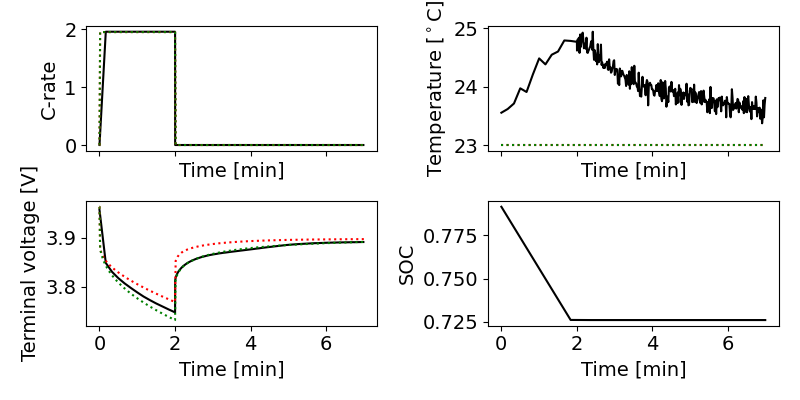

In [164]:
Dp_0 = 8.0E-15
Dn_0 = 8.0E-14
lb = np.array([1e-1])
ub = np.array([1e1])

for i,j in zip(i2[pulse_num:pulse_num+1],i2[pulse_num+1:pulse_num+2]):

    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()
       
    # Fit D
    # if SOC_0 < 0.2:
    #     k0 = np.array([0.8, 1])
    # else:
    #     k0 = np.array([SOC_0,1])   
    k0 = np.array([SOC_0])   
    kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg

    # iters = 0
    # rmse_V = simulate_pulse(k0)
    # while  rmse_V > 0.002 and iters<3:  
    #     k = dfols.solve(simulate_pulse, k0, bounds = (lb,ub), rhoend=1e-2)
    #     k0 = k.x
    #     rmse_V = simulate_pulse(k0)
    #     iters = iters+1
    #     print(iters)
    
    # simulate with k
    solutions = []
    # nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        # "Negative electrode diffusivity [m2.s-1]": Dn_0,
        # "Negative electrode thickness [m]":62E-06*4.2/5,
        # "Positive electrode thickness [m]":67E-06*4.2/5,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim0.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*kp.x[0],
        # "Negative electrode diffusivity [m2.s-1]": Dn_0*k.x[1],
        })
        
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    plot_pulse(pulse,solutions)



In [ ]:
k_list.append(k.x[:])
k0_list.append(k0)
SOC_list.append(pulse.SOC.iloc[-1])  
e_list.append(simulate_pulse(k.x))

In [188]:
# save parameters and soc 
Ds = pd.DataFrame(columns=('SOC', 'kp','kn','e', 'k0'))
for i,(k, soc, e, k0) in enumerate(zip(k_list, SOC_list, e_list, k0_list)):
   Ds.loc[i] = [soc, k[0], k[1],e[0], k0[:]]

display(Ds)
# Ds.to_csv('./fast_discharge/Ds8_rmse_V.csv',sep='\t')

,SOC,kp,kn,e,k0
0,0.428726,0.218644,1.191671,0.004071,"[0.50013484047955, 1.0]"


# Fit all pulses (positive and negative)

2023-07-20 22:07:53.561 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:07:53.696 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


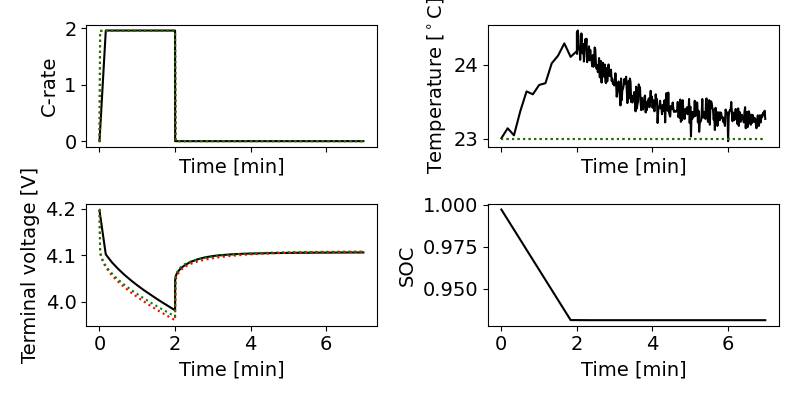

2023-07-20 22:08:07.248 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:08:07.391 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


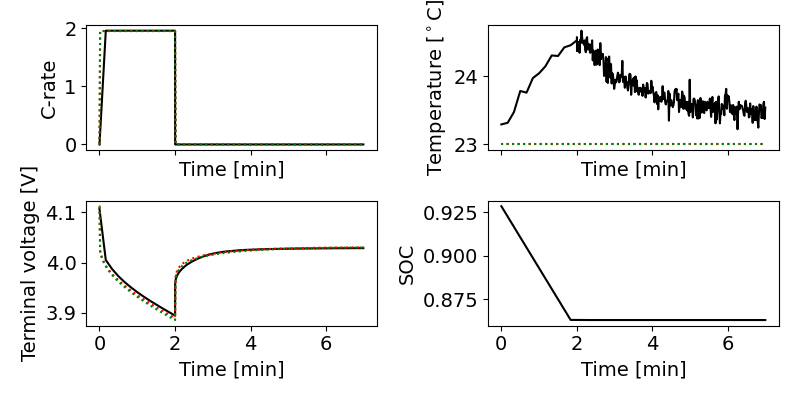

2023-07-20 22:08:29.313 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:08:29.449 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


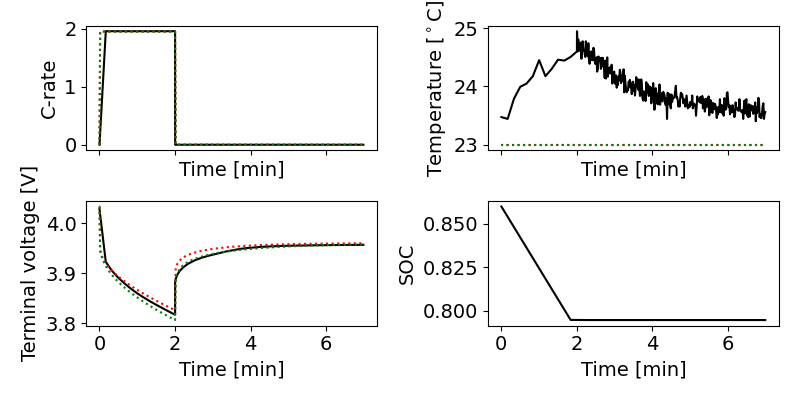

2023-07-20 22:08:51.050 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:08:51.174 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


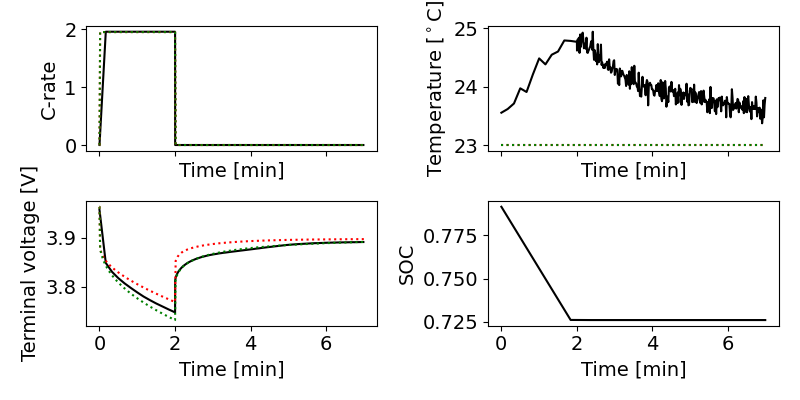

2023-07-20 22:09:08.254 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:09:08.386 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


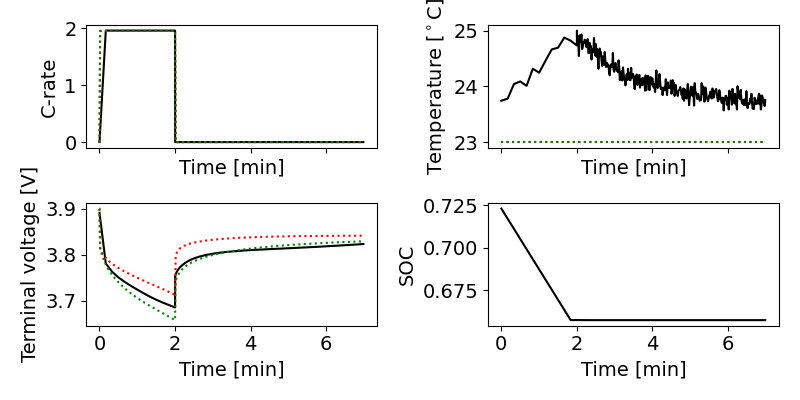

2023-07-20 22:09:33.385 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:09:33.518 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


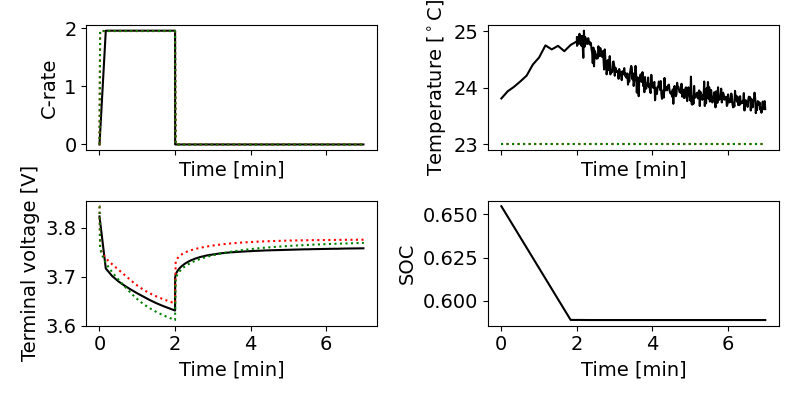

2023-07-20 22:09:57.978 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:09:58.104 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


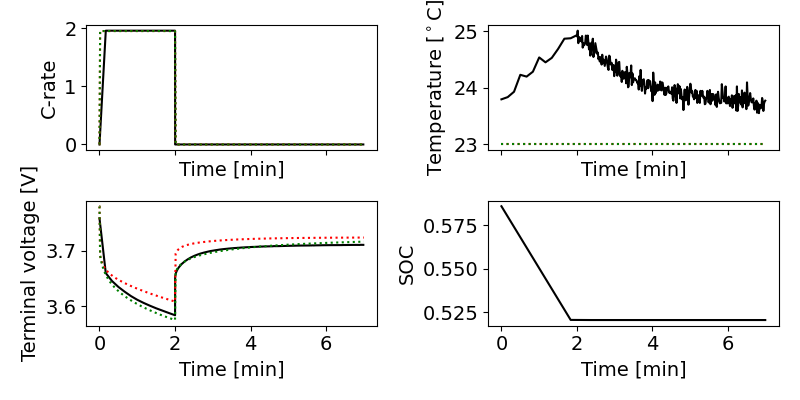

2023-07-20 22:10:15.070 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:10:15.203 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


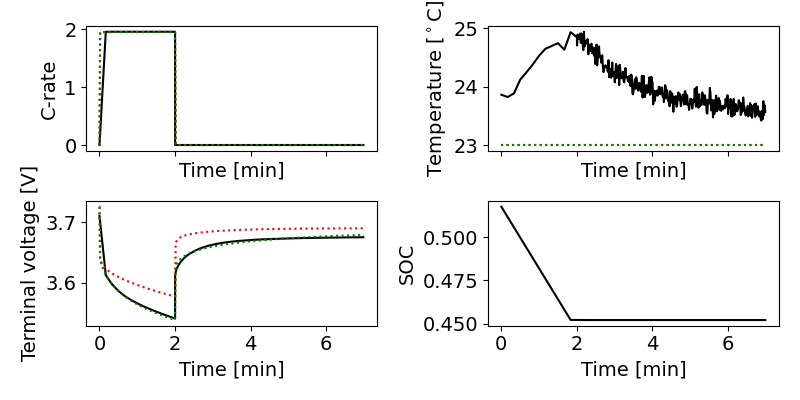

2023-07-20 22:10:29.853 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:10:30.007 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


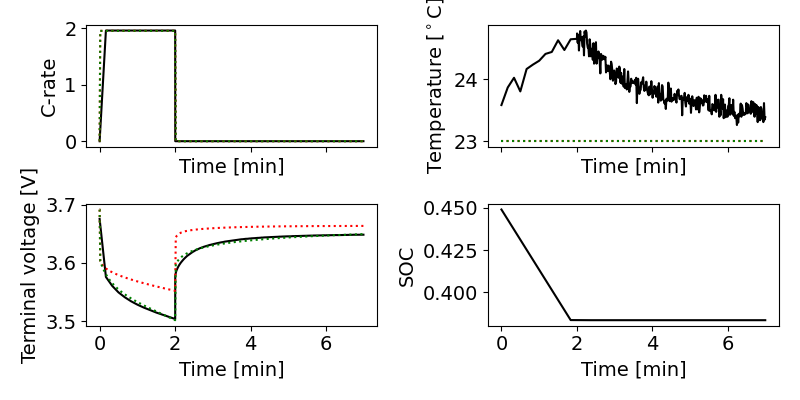

2023-07-20 22:10:42.833 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:10:43.000 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


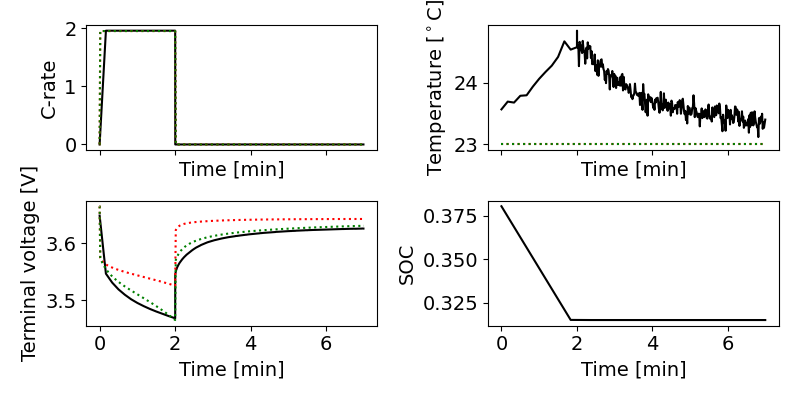

2023-07-20 22:11:07.477 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:07.648 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


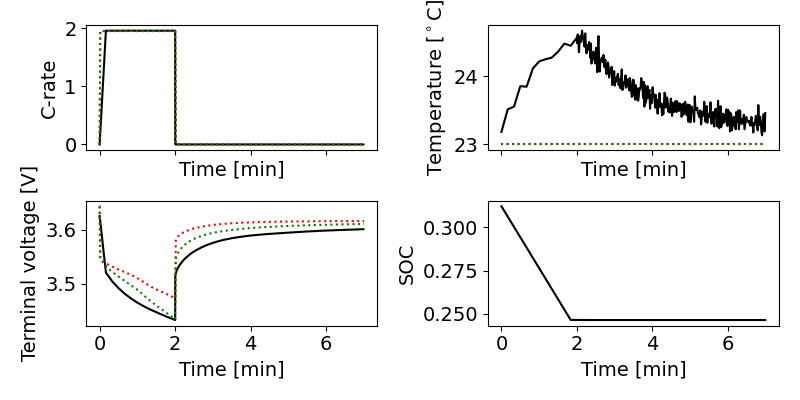

2023-07-20 22:11:38.821 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:38.989 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


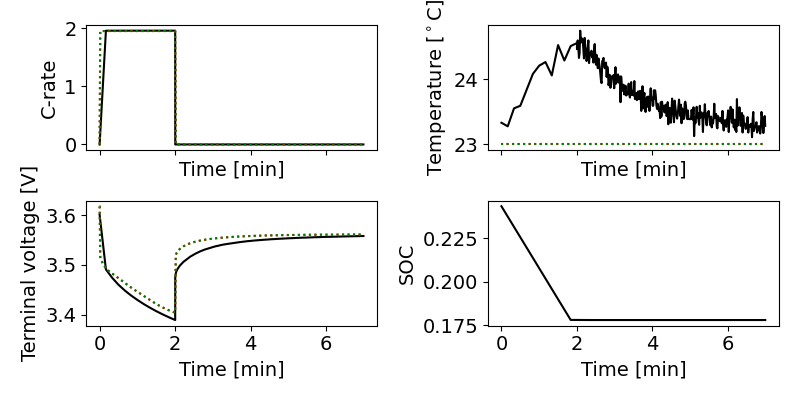

2023-07-20 22:11:41.025 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:42.672 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:45.474 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:47.235 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:48.992 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:50.814 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:52.558 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-20 22:11:56.200 - [WARNING] processed_variable.__call__(459): Calling varia

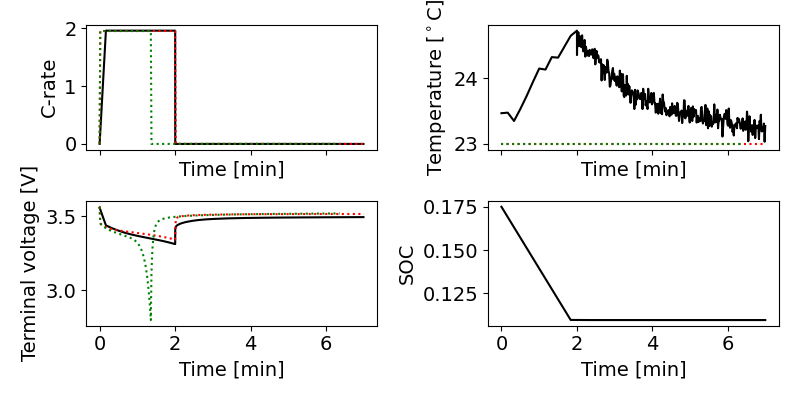

In [165]:
Dp_0 = 8.0E-15
Dn_0 = 8.0E-14
lb = np.array([1e-1]*2)
ub =  np.array([1e1]*2)
k_list = []                               
SOC_list = []
e_list = []
for c,(i,j) in enumerate(zip(i2[0:-1],i2[1::])):

    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()
       
    # Fit D
    # if SOC_0 < 0:
    loss_function = simulate_pulse
    k0 = np.array([SOC_0]*2)
    # k = dfols.solve(loss_function, k0, bounds = (lb,ub), rhoend=1e-2)
    # # if c ==0:
    #     # k0 = np.array([SOC_0,1])
    # # else:
    #     # k0 = k_list[-1]
    # # k0 = np.array([SOC_0, 1])            
    # # kpn = dfols.solve(simulate_pulse, k0, bounds = (lb,ub), rhoend=1e-2) # fit pos and neg
    kp = dfols.solve(simulate_pulse_pos, np.array([SOC_0]), args=(np.array([SOC_0])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg

    # # pulse = pulse[pulse.I>0]
    # # pulse_current = pulse[['t','I']].to_numpy()
    # kn = dfols.solve(simulate_pulse_neg, np.array([SOC_0]), args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    k = np.array([kp.x[0], 1])
    k_list.append(k)
    SOC_list.append(pulse.SOC.iloc[-1])  
    e_list.append(loss_function(k))

    # simulate with k
    solutions = []
    # nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim0.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k_list[c][0],
        # "Negative electrode diffusivity [m2.s-1]": Dn_0*k_list[c][1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    plot_pulse(pulse,solutions)


In [170]:
# save parameters and soc 
Ds = pd.DataFrame(columns=('SOC', 'kp','kn','e'))
for i,(k, soc, e) in enumerate(zip(k_list, SOC_list, e_list)):
   if  (k[0]) and (k[1]):
      Ds.loc[i] = [soc, k[0], k[1], e[0]]

display(Ds)
Ds.to_csv('./fast_discharge/Ds104.csv')

,SOC,kp,kn,e
0,0.931499,1.197024,1.0,0.004658
1,0.862995,0.903524,1.0,0.004726
2,0.794493,0.635020,1.0,0.004851
3,0.725995,0.414845,1.0,0.005212
4,0.657494,0.247316,1.0,0.017639
5,0.588994,0.334518,1.0,0.020932
6,0.520495,0.276019,1.0,0.007346
7,0.451993,0.175084,1.0,0.005790
8,0.383496,0.105000,1.0,0.006716
9,0.314995,0.100000,1.0,0.021704


# Fit concentration dependence

# Polyfit concentration dependence

In [167]:
def polystr(pk):    
    label = []
    for i, p in enumerate(pk):
        #coeff
        label.append(str(round(p,3)))

        # x^n
        if len(pk)-i-1>1:
            label.append('$x^' + str(len(pk)-i-1) + '$' + ' + ')
        elif i== len(pk)-2:
            label.append('$x$'  + ' + ')

    return ''.join(label)

In [168]:
# Ds0 = pd.read_csv('./fast_discharge/Ds101.csv', usecols=range(1,4), sep = '\t') #
Ds0 = pd.read_csv('./fast_discharge/Ds104.csv', usecols=range(1,5)) #, sep = '\t'
display(Ds0)

,SOC,kp,kn,e
0,0.931499,1.197024,1.0,0.004658
1,0.862995,0.903524,1.0,0.004726
2,0.794493,0.635020,1.0,0.004851
3,0.725995,0.414845,1.0,0.005212
4,0.657494,0.247316,1.0,0.017639
5,0.588994,0.334518,1.0,0.020932
6,0.520495,0.276019,1.0,0.007346
7,0.451993,0.175084,1.0,0.005790
8,0.383496,0.105000,1.0,0.006716
9,0.314995,0.100000,1.0,0.021704


[ 5.73752909 -5.65715456  1.51876706]
[-4.6177712e-16  1.0000000e+00]


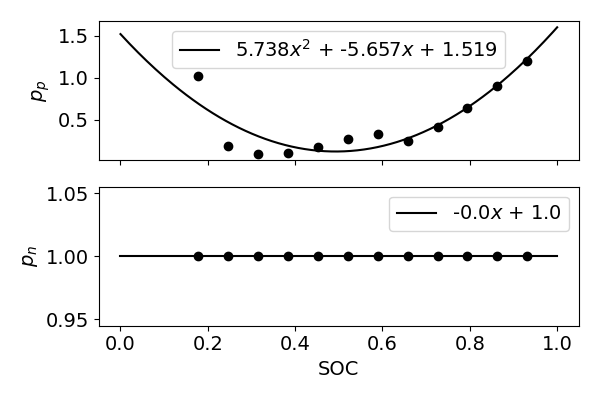

In [169]:
# load values
Ds = Ds0.iloc[0::]
Ds = Ds0[Ds0.e<0.1]

# polyfit data

pp = np.polyfit(Ds.SOC, Ds.kp,2) # low soc
pn = np.polyfit(Ds.SOC, Ds.kn,1) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp, color = 'k')
ax[0].plot(x, yp, label = polystr(pp) , color = 'k')
ax[0].set_ylabel('$p_p$')
ax[0].legend()
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn , color = 'k')
ax[1].plot(x, yn, label = polystr(pn), color = 'k')
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$p_n$')
# ax[1].set_ylim([0,2])
ax[1].legend()

# display(Ds)

print(pp)
print(pn)# Ds.loc[len(Ds.index)] = [0, np.nan, Ds.kn.iloc[-1], np.nan] 

plt.rcParams.update({'font.size': 14})
plt.savefig('./fast_discharge/figs/p.jpg', format='jpg')
plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 2.64404724 -2.28356604  0.77323284]
[0.59465548 0.38082411]


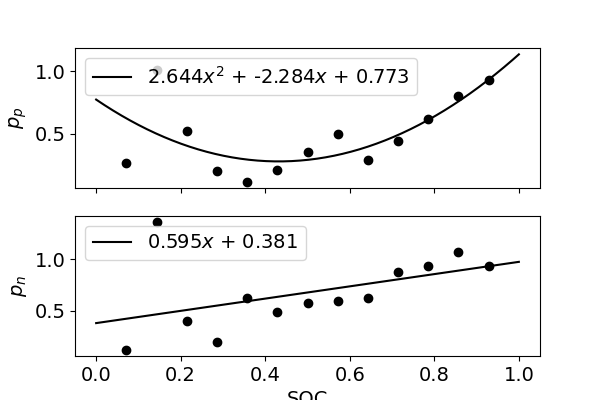

In [34]:
def monoExp(x, a, b):
    return a*(x)**b


# load values
Ds = Ds0.iloc[0::]
# Ds = Ds0[Ds0.e<0.009]

# polyfit data
pp = np.polyfit(Ds.SOC, Ds.kp,2) # low soc
pn = np.polyfit(Ds.SOC, Ds.kn,1) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)
# p0 = (1,0.5)
# params, cv = curve_fit(monoExp, Ds.SOC, Ds.kn, p0)
# a,b = params
# yn= a*(x+0.03)**b

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp, color = 'k')
ax[0].plot(x, yp, label = polystr(pp) , color = 'k')
ax[0].set_ylabel('$p_p$')
ax[0].legend()
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn , color = 'k')
ax[1].plot(x, yn, label = polystr(pn), color = 'k')
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$p_n$')
# ax[1].set_ylim([0,2])
ax[1].legend()

# display(Ds)

print(pp)
print(pn)# Ds.loc[len(Ds.index)] = [0, np.nan, Ds.kn.iloc[-1], np.nan] 

plt.savefig('./fast_discharge/figs/p.eps', format='eps')


[ 5.32189152 -5.72319492  1.7780767 ]
[-0.65600518  0.5899654   0.15770689]


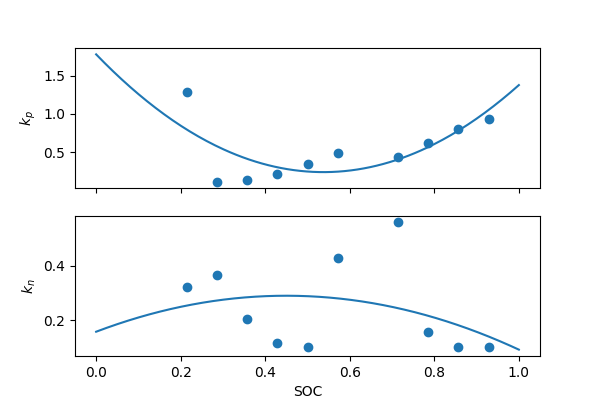

In [8]:
# load values
Ds0 = pd.read_csv('./fast_discharge/Ds13.csv', usecols=range(1,5))
Ds = Ds0[Ds0.e<0.008]

# polyfit data

pp = np.polyfit(Ds.SOC, Ds.kp,2) # low soc
pn = np.polyfit(Ds.SOC, Ds.kn,2) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp)
ax[0].plot(x, yp)
ax[0].set_ylabel('$k_p$')
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn)
ax[1].plot(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$k_n$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(pp)
print(pn)

In [ ]:
Ds

,SOC,kp,kn,e
1,0.857179,0.792933,1.155362,0.003367
2,0.785771,0.624047,1.273074,0.002276
3,0.714363,0.443500,1.397708,0.002052
4,0.642953,0.270809,1.397544,0.004815
5,0.571544,0.431176,1.387164,0.003244
6,0.500135,0.351810,1.522016,0.002597
7,0.428726,0.217888,1.522144,0.004088
8,0.357318,0.151866,0.162605,0.003504
9,0.285910,0.125638,0.313552,0.004312


[ 2.29468003 -1.19740116]
[ 2.45793142 -0.82752889  0.12563191]
[1.00000237 0.07140758]
[0.99999824 0.07140902]


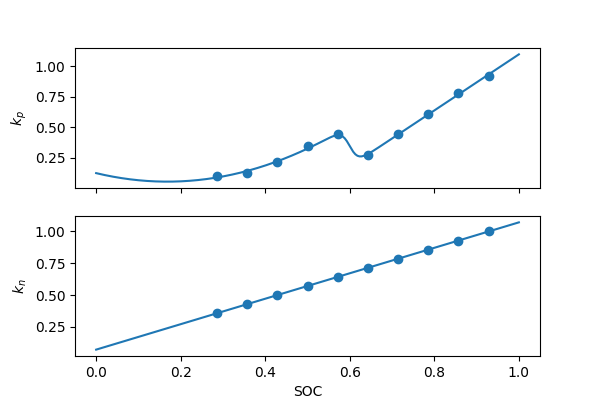

In [212]:
# load values
Ds0 = pd.read_csv('./fast_discharge/Ds12.csv', usecols=range(1,5))
Ds = Ds0[Ds0.e<0.008]
# polyfit data

pp_high = np.polyfit(Ds.SOC[0:5], Ds.kp[0:5],1) # high soc
pp_low = np.polyfit(Ds.SOC[5::], Ds.kp[5::],2) # low soc
pn_high = np.polyfit(Ds.SOC[Ds.SOC>0.4], Ds.kn[Ds.SOC>0.4],1) # high soc
pn_low = np.polyfit(Ds.SOC[Ds.SOC<0.4], Ds.kn[Ds.SOC<0.4],1) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp_high,x)*(1/(1 + np.exp(-(x-0.6)*100)))+ np.polyval(pp_low,x)*(1-1/(1 + np.exp(((0.6-x)*100))))
yn = np.polyval(pn_high,x)*(1/(1 + np.exp(-(x-0.4)*20)))+ np.polyval(pn_low,x)*(1-1/(1 + np.exp(((0.4-x)*20))))
# yn = np.polyval(pn1,x) + np.polyval(pn2,x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp)
ax[0].plot(x, yp)
ax[0].set_ylabel('$k_p$')
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn)
ax[1].plot(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$k_n$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(pp_high)
print(pp_low)
print(pn_high)
print(pn_low)

In [ ]:
Ds

,SOC,kp,kn
0,0.928590,0.942659,0.915940
1,0.857179,0.778717,0.996159
2,0.785771,0.625759,1.106700
3,0.714363,0.433340,1.101692
4,0.642953,0.269941,0.928569
5,0.571544,0.454229,0.971036
6,0.500135,0.359006,0.997634
7,0.428726,0.210167,1.193241
8,0.357318,0.125000,0.285557
9,0.285910,0.100000,0.572866


0


2023-04-14 13:24:40.700 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:41.230 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


1


2023-04-14 13:24:44.531 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:45.237 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


2


2023-04-14 13:24:48.733 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:49.208 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


3


2023-04-14 13:24:52.488 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:53.078 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


4


2023-04-14 13:24:57.234 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:57.942 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


5


2023-04-14 13:25:02.122 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:02.761 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


6


2023-04-14 13:25:06.648 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:07.297 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


7


2023-04-14 13:25:10.753 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:11.494 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


8


2023-04-14 13:25:17.285 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:17.976 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


9


2023-04-14 13:25:21.285 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:21.937 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


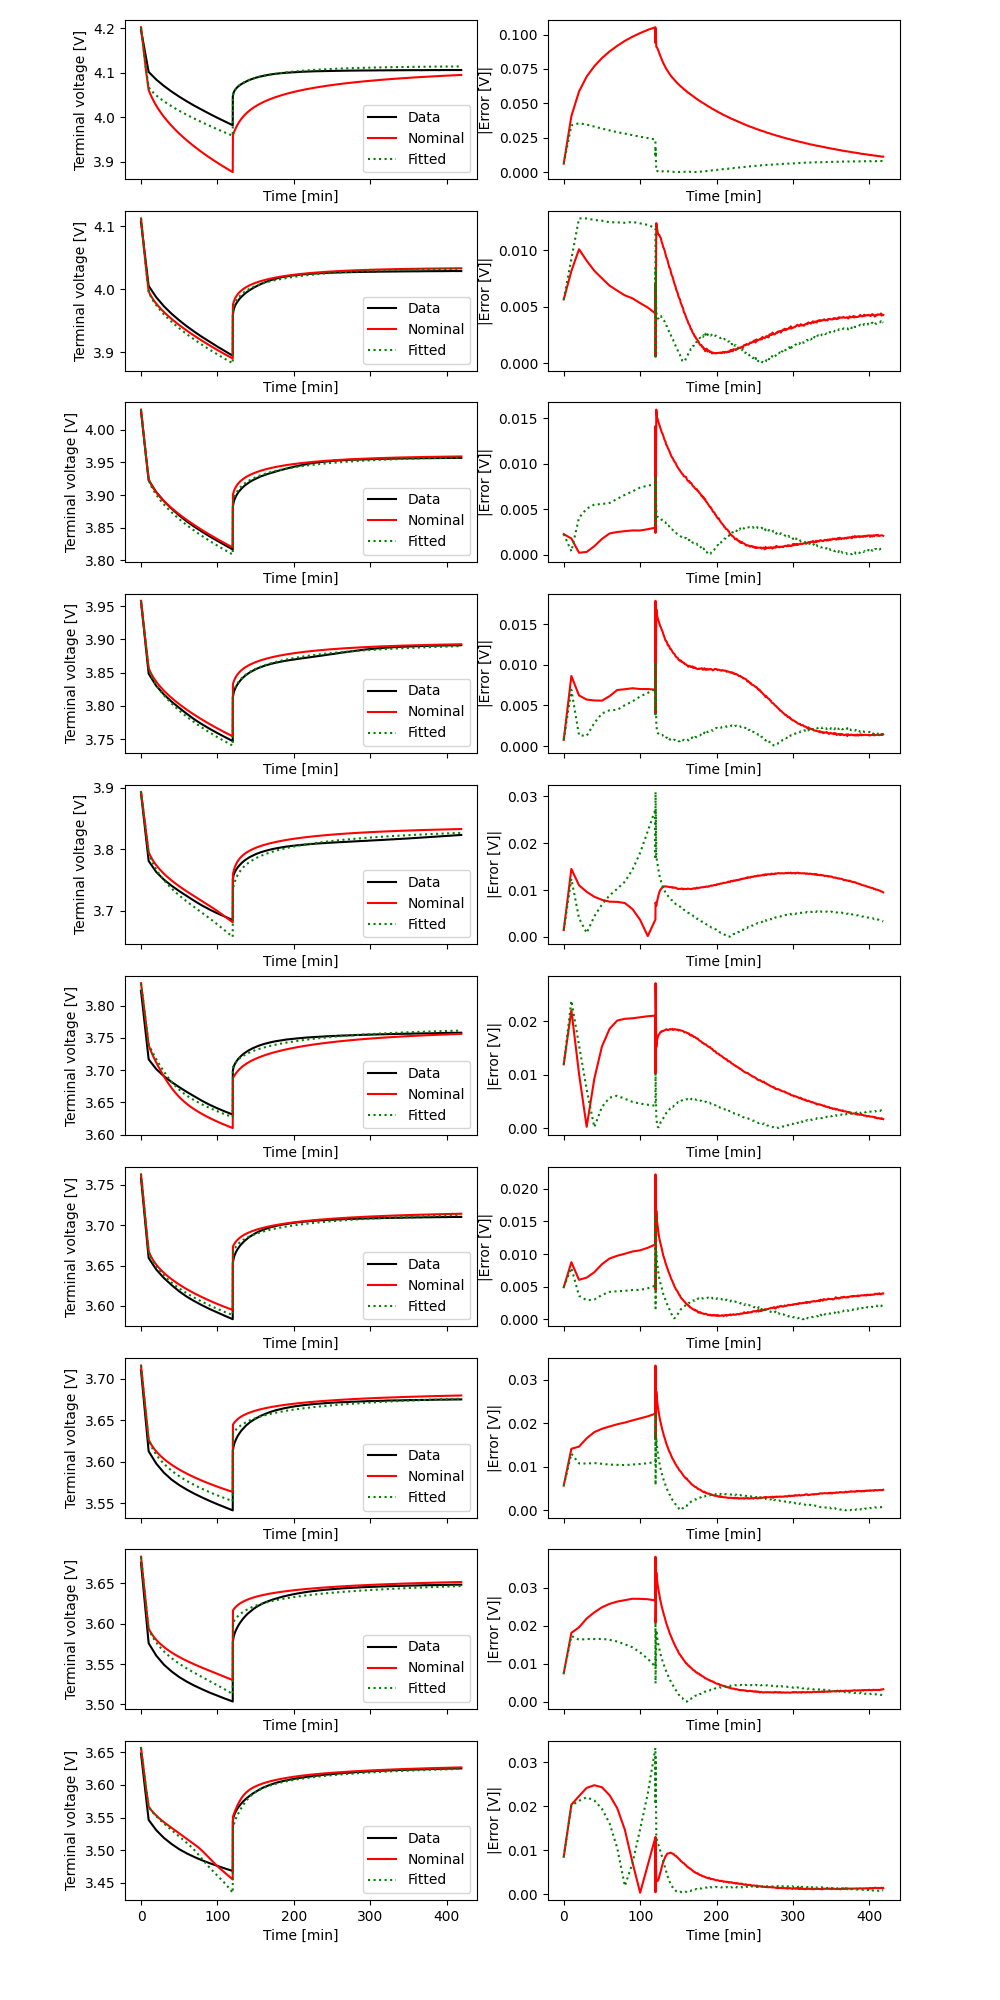

In [213]:
%matplotlib widget
fig, ax = plt.subplots(len(Ds), 2, figsize=(10,len(Ds)*2), sharex=True)
# ax = ax.flatten()

Dp_0 = 8.0E-15
Dn_0 = 8.0E-14

for k, (i,j) in enumerate(zip(i2[0:len(Ds)],i2[1::])):
    print(k)

    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    # simulate with k
    solutions = []
    # nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*Ds.iloc[k].kp,
        "Negative electrode diffusivity [m2.s-1]": Dn_0*Ds.iloc[k].kn,
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    ax[k,0].plot(pulse.t, pulse.V, color = 'k')
    ax[k,0].set_xlabel(xlabel)
    ax[k,0].set_ylabel('Terminal voltage [V]')
    
    colors = ['r','g']
    linestyles = ['-', ':']
    for j,solution in enumerate(solutions):
        t = solution["Time [s]"].entries
        V = solution['Terminal voltage [V]']
        ax[k,0].plot(t, V(t), color = colors[j], linestyle = linestyles[j])
        ax[k,0].legend(["Data", "Nominal", "Fitted"])

        e_V = abs(pulse.V - V(pulse.t))
        ax[k,1].plot(pulse.t, e_V, color = colors[j], linestyle = linestyles[j])
        ax[k,1].set_xlabel(xlabel)
        ax[k,1].set_ylabel('|Error [V]|')

plt.subplots_adjust(bottom=0.05, top=0.99)
        
    

# Curve fit concentration dependence (OReagan's form)

In [142]:
def Dsp_c(soc,a1,a2,a3,b1,b2,b3,c0,c1,c2,c3,c):
    # sto = (1-soc)*(1-y0)+0.353
    sto = (1-soc)*(0.837-0.034)+0.034
    # sto = 0.837-soc*(0.837-0.034)
    # soc = (0.837-sto)/(0.837-0.034)

    D_ref = (
            10
            ** (
                c0
                + a1 * np.exp(-((sto - b1) ** 2) / c1)
                + a2 * np.exp(-((sto - b2) ** 2) / c2)
                + a3 * np.exp(-((sto - b3) ** 2) / c3)
            )
            # *0.3672467477  # correcting factor (see O'Regan et al 2021)
            *c
        )

    return D_ref


def Dsn_c(sto,a1,a2,a3,b1,b2,b3,c0,c1,c2,c3,c):
    D_ref = (
            10
            ** (
                c0
                + a1 * np.exp(-((sto - b1) ** 2) / c1)
                + a2 * np.exp(-((sto - b2) ** 2) / c2)
                + a3 * np.exp(-((sto - b3) ** 2) / c3)
                # + a4 * np.exp(-((sto - b4) ** 2) / c4)

            )
            * c
        )

    return D_ref

[-4.75533191e-01 -1.02806727e+00 -8.28210929e-01  3.35919225e-01
  5.63142410e-01  8.30800724e-01 -1.38158037e+01  2.50322794e-02
  7.15484951e-03  1.65275022e-03  5.48265942e-01]


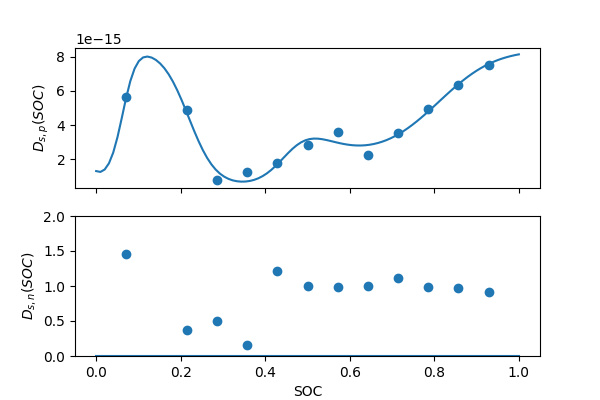

In [ ]:
# load values
Ds0 = pd.read_csv('./fast_discharge/Ds10.csv', usecols=range(1,5))
Ds = Ds0[Ds0.e<0.01]
Ds['Ds_p'] = Dp_0*Ds.kp
Ds['Ds_n'] = Dp_0*Ds.kn


# find curve fit parameters
# p0_p = [-0.9231, -0.4066,-0.993,0.3216,0.4532,0.8098,-13.96,0.002534,0.003926,0.09924,0.4]
p0_p = [-0.9231, -0.4066,-0.993,0.3216,0.4532,0.8098,-13.96,0.002534,0.003926,0.09924,0.4]
pp, covariance = curve_fit(Dsp_c, Ds.SOC, Ds.Ds_p, p0 = p0_p)
# p0_n = [11.17,-1.553,-6.136, -9.725,1.85,0.2031,0.5375,0.9144, 0.5953,-15.11,0.0006091,0.06438,0.0578,0.001356,2092]
p0_n = [-1.553,-6.136, -9.725,0.2031,0.5375,0.9144, -15.11,0.0006091,0.06438,0.0578,3.0321]
pn, covariance = curve_fit(Dsn_c, Ds.SOC, Ds.Ds_n, p0 = pp*10)

# calculate fitted values
x = np.linspace(0,1,100)
yp = Dsp_c(x,*pp)
yn = Dsn_c(x,*pn)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.Ds_p)
ax[0].plot(x, yp)
ax[0].set_ylabel('$D_{s,p}(SOC)$')
ax[1].scatter(Ds.SOC, Ds.kn)
ax[1].plot(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$D_{s,n}(SOC)$')
ax[1].set_ylim([0,2])

# display(Ds)

print(pp)
# print(pn)

# Curve fit concnetration dependent diffusion from literature

In [111]:
Dn = pd.read_csv('./fast_discharge/Levi Aurbach 1997 graphite diffusion.csv', header=None)
df_labels = ['SOC', 'Dn']
Dn.set_axis(df_labels, axis=1, inplace=True)
Dn.Dn = Dn.Dn
# display(Dn0)

Dp = pd.read_csv('./fast_discharge/Wu 2012 NMC diffusion.csv', header=None)
df_labels = ['SOC', 'Dp']
Dp.set_axis(df_labels, axis=1, inplace=True)
# display(Dp0)


C:\Users\Vivian\AppData\Local\Temp\ipykernel_21372\4208541996.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  Dn.set_axis(df_labels, axis=1, inplace=True)
C:\Users\Vivian\AppData\Local\Temp\ipykernel_21372\4208541996.py:9: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  Dp.set_axis(df_labels, axis=1, inplace=True)


In [293]:
def Dsp_c(soc,a1,a2,a3,b1,b2,b3,c0,c1,c2,c3,c):
    # sto = (1-soc)*(1-y0)+0.353
    # sto = (1-soc)*(0.837-0.034)+0.034
    # sto = 0.837-soc*(0.837-0.034)
    # soc = (0.837-sto)/(0.837-0.034)
    sto = (1-soc)*(1-0.034)+0.034
    # sto = soc
    D_ref = (
            10
            ** (
                c0
                + a1 * np.exp(-((sto - b1)/ c1)** 2 )
                + a2 * np.exp(-((sto - b2)/ c2)** 2 )
                + a3 * np.exp(-((sto - b3)/ c3)** 2 )
            )
            *c
            # *0.3672467477  # correcting factor (see O'Regan et al 2021)
        )

    return D_ref

def monoExp(x, a, b):
    return a*(x)**b


[4.72456394e-14 1.78059902e+00]


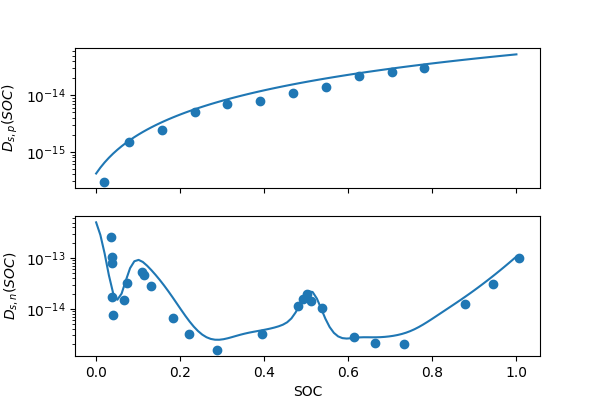

In [267]:
# calculate fitted values
x = np.linspace(0,1,100)
yn = 10**(
    -5.9401e-1*np.exp(-((x-2.5720e-1)/8.4006e-2)**2)\
    +5.1118e-1*np.exp(-((x-5.1715e-1)/1.0308e-1)**2)\
    -6.6628e-2*np.exp(-((x-7.5004e-1)/6.0470e-2)**2)\
    -1.9021e-1*np.exp(-((x-5.7634e-1)/4.1183e-2)**2)\
    +5.7993e-1*np.exp(-((x-5.0993e-1)/3.2647e-2)**2)\
    -1.0736e1*np.exp(-((x-5.5128e-1)/1.0588)**2)\
    -1.2463*np.exp(-((x-4.7459e-2)/3.0551e-2)**2)\
    -4
)

p0 = (1e-14,0.5)
params, cv = curve_fit(monoExp, Dp.SOC, Dp.Dp, p0)
a,b = params
yp = a*(x+0.07)**b
# y = (1-x)
# yp = 10**(
#     -1.3922e12*np.exp(-((y-4.0704)/5.8343e-1)**2)\
#     -1.4516e1*np.exp(-((y-1.0490)/1.8016)**2)\
#     -8.6982e-1*np.exp(-((y-3.0124e-1)/2.1998e-1)**2)\
#     # -8.6982e-1*np.exp(-((y-3.0124e-1)/2.1998e-1)**2)\

# )

# p0_p = [-1.3922e12, -1.4516e1,-8.6982e-1,4.0704,1.0490,3.0124e-1,0,5.8343e-1,1.8016,2.1998e-1,1]
# pp, covariance = curve_fit(Dsp_c, Dp.SOC, Dp.Dp, p0 = p0_p)
# yp = Dsp_c(x,*pp)

# pp = np.polyfit(Dp.SOC, np.log(Dp.Dp), 1)
# a = np.exp(pp[1])
# b = pp[0]
# yp = a * np.exp(b * x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Dp.SOC, Dp.Dp)
ax[0].semilogy(x, yp)
ax[0].set_ylabel('$D_{s,p}(SOC)$')


ax[1].scatter(Dn.SOC, Dn.Dn)
ax[1].semilogy(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$D_{s,n}(SOC)$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(params)
# print(pn)

In [256]:
yp[0]

2.279024502808816e-16

[  5.10131478 -34.67348865]


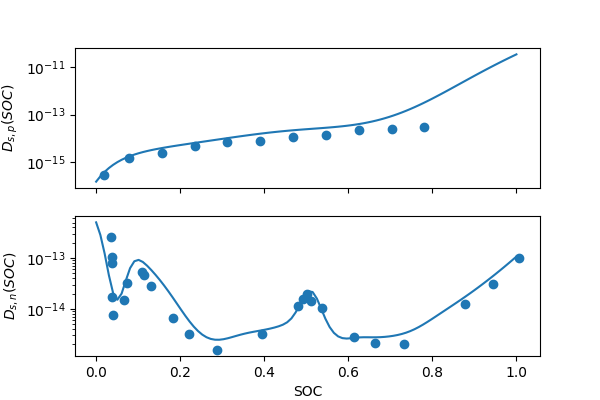

In [227]:
# calculate fitted values
x = np.linspace(0,1,100)
yn = 10**(
    -5.9401e-1*np.exp(-((x-2.5720e-1)/8.4006e-2)**2)\
    +5.1118e-1*np.exp(-((x-5.1715e-1)/1.0308e-1)**2)\
    -6.6628e-2*np.exp(-((x-7.5004e-1)/6.0470e-2)**2)\
    -1.9021e-1*np.exp(-((x-5.7634e-1)/4.1183e-2)**2)\
    +5.7993e-1*np.exp(-((x-5.0993e-1)/3.2647e-2)**2)\
    -1.0736e1*np.exp(-((x-5.5128e-1)/1.0588)**2)\
    -1.2463*np.exp(-((x-4.7459e-2)/3.0551e-2)**2)\
    -4
)

y = (1-x)
yp = 10**(
    -1.3922e12*np.exp(-((y-4.0704)/5.8343e-1)**2)\
    -1.4516e1*np.exp(-((y-1.0490)/1.8016)**2)\
    -8.6982e-1*np.exp(-((y-3.0124e-1)/2.1998e-1)**2)\
)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Dp.SOC, Dp.Dp)
ax[0].semilogy(x, yp)
ax[0].set_ylabel('$D_{s,p}(SOC)$')


ax[1].scatter(Dn.SOC, Dn.Dn)
ax[1].semilogy(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$D_{s,n}(SOC)$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(pp)
# print(pn)